In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
from scipy import stats

In [2]:
root_dir = '/scratch3-shared/phil/berzelius_non_grit_based/' # user should change this path accordingly
bf_file = 'bf_11cls_basic_aug_dmsonorm_750e_sgd/ResNet_resnet50/analysis.csv'
fl_file = 'fl_11cls_basic_aug_dmso_norm_750e_sgd/ResNet_resnet50/analysis.csv'
cp_file = 'bf_11cls_basic_aug_dmsonorm_750e_sgd/ResNet_resnet50/cp_moa_analysis.csv'
grit_stats = pd.read_csv('~/SPECS_phil/stats/grit_stats.csv', sep=',') # user should change path to stats folder

for split in range(1, 6):
    bf_split = pd.read_csv(root_dir + 'bf_exps_1_split' + str(split) + '/' + bf_file, index_col=0)
    bf_split['split'] = np.repeat(split, len(bf_split))
    
    fl_split = pd.read_csv(root_dir + 'fl_exps_1_split' + str(split) + '/' + fl_file, index_col=0)
    fl_split['split'] = np.repeat(split, len(fl_split))
    
    cp_split = pd.read_csv(root_dir + 'bf_exps_1_split' + str(split) + '/' + cp_file)
    cp_split['split'] = np.repeat(split, len(cp_split))
    
    if split == 1:
        bf_df = bf_split
        fl_df = fl_split
        cp_df = cp_split
    else:
        bf_df = pd.concat([bf_df, bf_split], ignore_index=True, sort=False)
        fl_df = pd.concat([fl_df, fl_split], ignore_index=True, sort=False)
        cp_df = pd.concat([cp_df, cp_split], ignore_index=True, sort=False)

In [3]:
comps = np.unique(bf_df.compound)
comp_bf_acc = np.zeros(len(comps))
comp_fl_acc = np.zeros(len(comps))
comp_cp_acc = np.zeros(len(comps))
comp_moa = []
comp_grit_mean = np.zeros(len(comps))
comp_grit_std = np.zeros(len(comps))
comp_ncount = np.zeros(len(comps))
comp_ncount_std = np.zeros(len(comps))

for i, comp in enumerate(comps):
    sub_bf_pred = np.array(bf_df[bf_df['compound']==comp].pred_moa)
    sub_fl_pred = np.array(fl_df[fl_df['compound']==comp].pred_moa)
    sub_cp_pred = np.array(cp_df[cp_df['compound']==comp].pred_moa)
    sub_lab = np.array(bf_df[bf_df['compound']==comp].moa)
    sub_lab_cp = np.array(cp_df[cp_df['compound']==comp].moa)
    comp_moa.append(sub_lab[0])
    comp_bf_acc[i] = ((sub_bf_pred == sub_lab).sum() / len(sub_lab)).item()
    comp_fl_acc[i] = ((sub_fl_pred == sub_lab).sum() / len(sub_lab)).item()
    comp_cp_acc[i] = ((sub_cp_pred == sub_lab_cp).sum() / len(sub_lab_cp)).item()
    
    if comp == 'dmso':
        comp_grit_mean[i] = np.nan
        comp_grit_std[i] = np.nan
        comp_ncount[i] = np.nan
        comp_ncount_std[i] = np.nan
    else:
        comp_grit_mean[i] = grit_stats[grit_stats['compound']==comp].grit_mean.values[0]
        comp_grit_std[i] = grit_stats[grit_stats['compound']==comp].grit_std.values[0]
        comp_ncount[i] = grit_stats[grit_stats['compound']==comp].count_nuclei_mean.values[0]
        comp_ncount_std[i] = grit_stats[grit_stats['compound']==comp].count_nuclei_std.values[0]
    
data = {'comp': comps,
        'acc_bf': comp_bf_acc,
        'acc_fl': comp_fl_acc,
        'acc_cp': comp_cp_acc,
        'moa': comp_moa,
        'grit_mean': comp_grit_mean,
        'grit_std': comp_grit_std,
        'nuclei_mean': comp_ncount,
        'nuclei_std': comp_ncount_std}
res = pd.DataFrame(data, columns = ['comp', 'acc_bf', 'acc_fl', 'acc_cp', 'moa', 'grit_mean', 'grit_std', 'nuclei_mean', 'nuclei_std'])

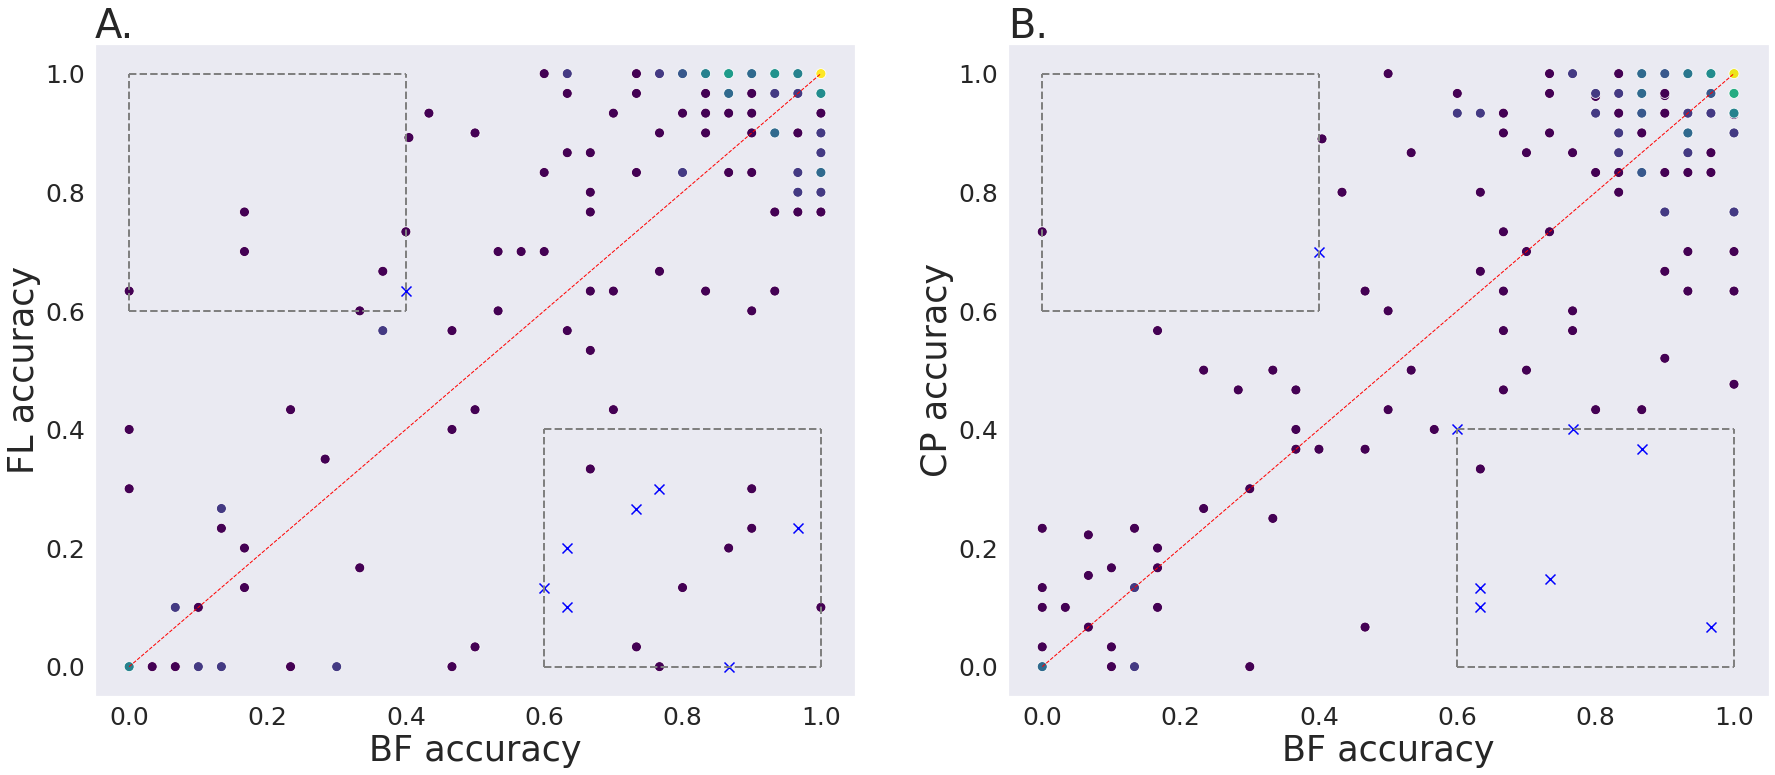

In [4]:
high_cut = 0.6
low_cut = 0.4

# bt = better than
bf_bt_fl = list(res[(res['acc_bf'] >= high_cut) & (res['acc_fl'] <= low_cut)].comp.values)
bf_bt_cp = list(res[(res['acc_bf'] >= high_cut) & (res['acc_cp'] <= low_cut)].comp.values)

fl_bt_bf = list(res[(res['acc_fl'] >= high_cut) & (res['acc_bf'] <= low_cut)].comp.values)
fl_bt_cp = list(res[(res['acc_fl'] >= high_cut) & (res['acc_cp'] <= low_cut)].comp.values)

cp_bt_bf = list(res[(res['acc_cp'] >= high_cut) & (res['acc_bf'] <= low_cut)].comp.values)
cp_bt_fl = list(res[(res['acc_cp'] >= high_cut) & (res['acc_fl'] <= low_cut)].comp.values)

bf_best = list(set(bf_bt_fl) & set(bf_bt_cp))
bf_worst = list(set(fl_bt_bf) & set(cp_bt_bf))

compx = bf_best + bf_worst # compounds to have an x in the plots

res_i = res.iloc[list(np.where(~res.comp.isin(compx))[0])].reset_index(drop=True)
res_x = res.iloc[list(np.where(res.comp.isin(compx))[0])].reset_index(drop=True)

bf_fl = res_i[['acc_bf', 'acc_fl']].copy()
bf_fl = bf_fl.groupby(['acc_bf','acc_fl']).size().reset_index().rename(columns={0:'count'})
bf_fl['log_count'] = np.log(bf_fl['count'])

bf_cp = res_i[['acc_bf', 'acc_cp']].copy()
bf_cp = bf_cp.groupby(['acc_bf','acc_cp']).size().reset_index().rename(columns={0:'count'})
bf_cp['log_count'] = np.log(bf_cp['count'])

fl_cp = res_i[['acc_fl', 'acc_cp']].copy()
fl_cp = fl_cp.groupby(['acc_fl','acc_cp']).size().reset_index().rename(columns={0:'count'})
fl_cp['log_count'] = np.log(fl_cp['count'])

hue_max = np.max([np.max(bf_fl['log_count']), np.max(bf_cp['log_count']), np.max(fl_cp['log_count'])])

sns.set_theme(style="dark")
fig = plt.figure(figsize=(30,12))

ax = fig.add_subplot(121)
sns.scatterplot(x=bf_fl['acc_bf'], y=bf_fl['acc_fl'], s=100, hue=bf_fl['log_count'], hue_norm=(0,hue_max), palette='viridis', legend=False)
plt.scatter(res_x['acc_bf'], res_x['acc_fl'], marker='x', s=100, color='blue')

plt.plot([0.6, 1], [0.4, 0.4], color='gray', linestyle='--', linewidth=2)
plt.plot([0.6, 0.6], [0, 0.4], color='gray', linestyle='--', linewidth=2)
plt.plot([1, 1], [0, 0.4], color='gray', linestyle='--', linewidth=2)
plt.plot([0.6, 1], [0, 0], color='gray', linestyle='--', linewidth=2)

plt.plot([0, 0.4], [1, 1], color='gray', linestyle='--', linewidth=2)
plt.plot([0, 0.4], [0.6, 0.6], color='gray', linestyle='--', linewidth=2)
plt.plot([0, 0], [0.6, 1], color='gray', linestyle='--', linewidth=2)
plt.plot([0.4, 0.4], [0.6, 1], color='gray', linestyle='--', linewidth=2)

rho = round(stats.pearsonr(res.acc_bf, res.acc_fl)[0],3)
at = AnchoredText(
    r' $\rho = $' + str(rho),
    prop=dict(size=35), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
at.patch.set(alpha=0.1)
#ax.add_artist(at)

ax.set_title('A.', loc='left', fontsize=40)
ax.set_xlabel('BF accuracy', fontsize=35)
ax.set_ylabel('FL accuracy', fontsize=35)
plt.plot([0,1], [0,1], c='red', linestyle='dashed', linewidth=1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

ax = fig.add_subplot(122)
sns.scatterplot(x=bf_cp['acc_bf'], y=bf_cp['acc_cp'], s=100, hue=bf_cp['log_count'], hue_norm=(0,hue_max), palette='viridis', legend=False)
plt.scatter(res_x['acc_bf'], res_x['acc_cp'], marker='x', s=100, color='blue')

plt.plot([0.6, 1], [0.4, 0.4], color='gray', linestyle='--', linewidth=2)
plt.plot([0.6, 0.6], [0, 0.4], color='gray', linestyle='--', linewidth=2)
plt.plot([1, 1], [0, 0.4], color='gray', linestyle='--', linewidth=2)
plt.plot([0.6, 1], [0, 0], color='gray', linestyle='--', linewidth=2)

plt.plot([0, 0.4], [1, 1], color='gray', linestyle='--', linewidth=2)
plt.plot([0, 0.4], [0.6, 0.6], color='gray', linestyle='--', linewidth=2)
plt.plot([0, 0], [0.6, 1], color='gray', linestyle='--', linewidth=2)
plt.plot([0.4, 0.4], [0.6, 1], color='gray', linestyle='--', linewidth=2)

rho = round(stats.pearsonr(res.acc_bf, res.acc_cp)[0],3)
at = AnchoredText(
    r' $\rho = $' + str(rho), 
    prop=dict(size=35), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
at.patch.set(alpha=0.1)
#ax.add_artist(at)
ax.set_title('B.', loc='left', fontsize=40)
ax.set_xlabel('BF accuracy', fontsize=35)
ax.set_ylabel('CP accuracy', fontsize=35)
plt.plot([0,1], [0,1], c='red', linestyle='dashed', linewidth=1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig('acc_compare_11c.png', bbox_inches='tight', format='png')

plt.show()
plt.close()

In [5]:
res[res.comp.isin(bf_best)]

,comp,acc_bf,acc_fl,acc_cp,moa,grit_mean,grit_std,nuclei_mean,nuclei_std
76,CBK288281,0.766667,0.300000,0.400000,Aurora kinase inhibitor,3.041344,0.366161,83.153846,27.324264
82,CBK288327,0.633333,0.200000,0.133333,JAK inhibitor,4.653966,0.428043,36.666667,14.852736
126,CBK290766,0.633333,0.100000,0.100000,Aurora kinase inhibitor,6.335742,1.416790,18.181818,4.354726
167,CBK308126,0.866667,0.000000,0.366667,JAK inhibitor,4.779852,0.412948,74.277778,26.868946
173,CBK308276,0.966667,0.233333,0.066667,retinoid receptor agonist,3.829755,0.688179,136.938776,53.851032
220,CBK309507,0.733333,0.266667,0.148148,ATPase inhibitor,NaN,NaN,NaN,NaN
230,CBK309655,0.600000,0.133333,0.400000,topoisomerase inhibitor,4.992372,1.244041,46.000000,18.474081


In [6]:
res[res.comp.isin(bf_worst)]

,comp,acc_bf,acc_fl,acc_cp,moa,grit_mean,grit_std,nuclei_mean,nuclei_std
3,CBK017131,0.4,0.633333,0.7,topoisomerase inhibitor,0.549622,0.430047,133.078431,49.150318
